In [2]:
%config Completer.use_jedi = False
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
    
print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
sc.pp.normalize_total(adata, target_sum=1e6) #normalize data to CPM (counts per million)
        
print('Restrict to interaction genes')
genes = np.unique(interactions)
genes = [i for i in genes if i in adata.var_names]
# genes = genes - ['CCL3L3', 'CCL4L1', 'CCN6', 'KIR3DS1', 'YARS1']
adatag = adata[:, genes]

Load interaction
Load high-quality cells only
Restrict to interaction genes


/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [3]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']
from adata_utilis import split_adata
adata_dic = split_adata(adata)

In [2]:
from log2_FC_functions import log2_FC_all

gbs = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

adata_gb = {}
log2_fc_all = {}
log2_fc_ave = pd.DataFrame([])

for gb in gbs:
    adata_gb[gb] = adata[adata.obs['cell_type'] == gb]
    
    log2_fc_all[gb] = log2_FC_all(genes, adata_gb[gb], 'S_dengue', 'dengue', 'child')[1]
    log2_fc_all[gb]['cell_type']=[gb]*log2_fc_all[gb].shape[0]
    log2_fc_ave = pd.concat([log2_fc_ave, log2_fc_all[gb]])

log2_fc_ave['gene'] = log2_fc_ave.index.values
log2_fc_ave = log2_fc_ave.set_index('cell_type')

In [4]:
#from collections import defaultdict

#adatag_children = adatag[adatag.obs['dataset'] == 'child']
#cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
#conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']

#adatag_ch_ct_cd = {}
#for cell_type in cell_types:
#    for condition in conditions:
#        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

#gene_exp = {}
#for key in adatag_ch_ct_cd.keys():
#    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
#    gene_exp[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

from numpy import * # 调用numpy所有函数

adatag_children = adatag[adatag.obs['dataset'] == 'child']

D_IDs = list(adata_children[adata_children.obs['Condition'].isin(['dengue'])].obs['ID'].astype('category').cat.categories)
SD_IDs = list(adata_children[adata_children.obs['Condition'].isin(['S_dengue'])].obs['ID'].astype('category').cat.categories)
IDs = list(adata_children.obs['ID'].astype('category').cat.categories)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']
from collections import defaultdict
adatag_ch_ct_cd_ID = {}
adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition]
        for ID in IDs:
            adatag_ch_ct_cd_ID[(cell_type, condition, ID)] = adatag_ch_ct_cd[(cell_type, condition)][adatag_ch_ct_cd[(cell_type, condition)].obs['ID'] == ID]

gene_exp_ave = {}
for key in adatag_ch_ct_cd.keys():
    condition = key[1]
    exp = []
    for ID in list(adata_children[adata_children.obs['Condition'].isin([condition])].obs['ID'].astype('category').cat.categories):
        exp.append((adatag_ch_ct_cd_ID[(key[0], key[1], ID)].X > 0).toarray().mean(axis=0))
    exp_ave = np.array(exp).mean(axis=0)
    gene_exp_ave[key] = pd.DataFrame(exp_ave, index=adatag_ch_ct_cd[key].var.index, columns=['gene_expre'])

    
exp_fra_ave = pd.DataFrame([])
for key in gene_exp_ave.keys():
    gene_exp_ave[key]['cell_type'] = [key[0]]*(gene_exp_ave[key].shape[0])
    gene_exp_ave[key]['condition'] = [key[1]]*(gene_exp_ave[key].shape[0])
    #exp_fra = pd.DataFrame([], columns=['gene', 'exp_fra_ave'], index=key)
    exp_fra_ave = pd.concat([exp_fra_ave, gene_exp_ave[key]])
    exp_fra_ave['gene'] = exp_fra_ave.index
    exp_fra_ave.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/exp_fra_ave.tsv')
    

In [25]:
log2fc = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/all_log2_fc_ave_adults.tsv', index_col=['cell_type', 'gene']) 
from scipy import stats as ss
from collections import defaultdict

stas = []
p_value = []
idx = []

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
cds = ['S_dengue', 'dengue']

adata_ch = {(ct, cd): adata_adults[(adata_adults.obs['Condition'] == cd) & (adata_adults.obs['cell_type'] == ct)] for ct in cell_types for cd in cds}      


/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
#df = adata_ch.obs[['cell_type', 'Condition']].copy()
for gene in log2fc.loc['B_cells'].index.tolist():
    #df[gene] = adata_ch[:, gene].X.toarray()[:, 0]
    for cell_type in ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']:
        SD = adata_ch[(cell_type, 'S_dengue')][:, gene].X.toarray()[:, 0]
        D = adata_ch[(cell_type, 'dengue')][:, gene].X.toarray()[:, 0]
        #SD = SD.copy()
        #np.random.shuffle(SD)
        #SD = SD[:100]
        SD = np.random.choice(SD, size=100)#, replace=False
        D = np.random.choice(D, size=100)#, replace=False
        
        res = ss.ks_2samp(SD, D, alternative='two-sided')
        
        idx.append([cell_type, gene])
        stas.append(res[0])
        p_value.append(res[1])

ks_res = pd.DataFrame([], index=pd.Index(idx))
ks_res['statistic'] = stas
ks_res['p_value'] = p_value

ks_res['cell_type'] = [i[0] for i in ks_res.index]
ks_res['gene'] = [i[1] for i in ks_res.index]

ks_res.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/all_ks_res_ave_adults.tsv')

In [69]:
ks_res = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/all_ks_res_ave_kids.tsv', index_col=['cell_type', 'gene'])
log2fc = log2fc.loc[ks_res.index]
log2fc['statistic'] = ks_res['statistic']
log2fc['p_value'] = ks_res['p_value']

log2fc.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/all_log2_fc_ave_kids.tsv')

In [3]:
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=0)
log2fc_ad = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_adults.tsv', index_col=0)

#log2fc_kid_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/all_log2_fc_ave_kids.tsv', index_col=0) 
#log2fc_ad_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/all_log2_fc_ave_adults.tsv', index_col=0) 

gene_exp_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/exp_fra_ave.tsv', index_col=['cell_type', 'condition'])
ave_exp_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/ave_exp_ave.tsv', index_col=['cell_type', 'condition'])

In [174]:
chem_up = pd.DataFrame([])
for gene in ['CCL2', 'CCL7', 'CCL8', 'CCL13']:
    g = log2fc_ad_all[log2fc_ad_all['gene'] == gene].T.head(1)
    g['gene'] = gene
    chem_up = pd.concat([chem_up, g], axis=0)
chem_up.set_index('gene')

cell_type,B_cells,Monocytes,NK_cells,Plasmablasts,T_cells,cDCs,pDCs
gene,,,,,,,
CCL2,0.034194,-2.581264,0.446821,0.0,0.03329,6.609555,0.316833
CCL7,0.0,1.328439,0.008019,0.0,0.003488,0.0,0.0
CCL8,0.089909,-0.278431,0.52961,0.086908,-0.111932,0.0,0.343882
CCL13,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
log2fc_kid_all[log2fc_kid_all['gene'] == 'ICOSLG']

,fold_2_change,comp_frac,gene
cell_type,,,
B_cells,-0.377627,0.28125,ICOSLG
Monocytes,-0.993263,0.28125,ICOSLG
NK_cells,0.458899,0.12500,ICOSLG
Plasmablasts,1.470230,0.62500,ICOSLG
T_cells,-0.240448,0.43750,ICOSLG
cDCs,-2.486217,0.12500,ICOSLG
pDCs,1.627640,0.25000,ICOSLG


In [21]:
log2fc_ad_all[log2fc_ad_all['gene'] == 'CD40LG']

,fold_2_change,comp_frac,gene
cell_type,,,
B_cells,-0.083039,0.375,CD40LG
Monocytes,1.176277,0.750,CD40LG
NK_cells,0.057729,0.500,CD40LG
Plasmablasts,0.000000,0.000,CD40LG
T_cells,0.118802,0.625,CD40LG
cDCs,0.000000,0.000,CD40LG
pDCs,0.098442,0.250,CD40LG


In [16]:
# interactions[(interactions['gene_name_a'] == 'CCR2') | (interactions['gene_name_b'] == 'CCR2')]

In [14]:
#last_inters_Mono[last_inters_Mono['gene_name_a'] == 'XCL1']


# inters with endothellial or epidermal ['FLT1', 'NRP1', 'ITGA10', 'ITGB3', 'RETN', 'AREG', 'ANGPT1', 'EREG', 'ACVRL1']
# ECM ['PLD2', 'FN1', 'COL8A2']
# communication of cells with their microenvironment 
# inters need further google ['MRC1', 'FLT3', 'NPW', 'IL1R1', 'IL23A', 'PLD2', 'ADORA2B', 'IL11RA']
# inters with Monocytes or immune ['CSF1', 'CD70' ] 
# strange ['INSL3', 'LRP5', 'ASGR2']
# 'ACVRL1': hemorrhagic telangiectasia type 2
# 'EPHA1', 'APP': nervous system, App AD

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


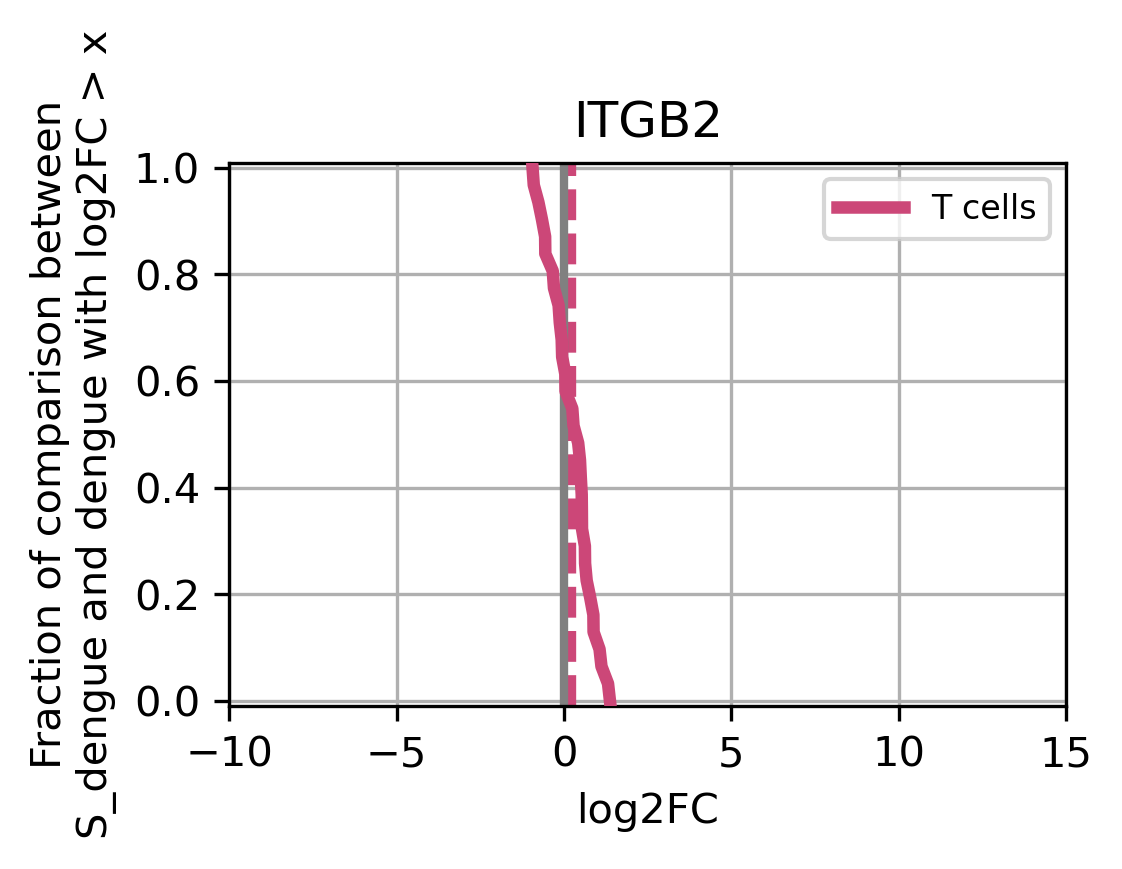

In [27]:
from log2_FC_functions import cul_plot_gene_cts
cul_plot_gene_cts(['ITGB2'], adata, 'S_dengue', 'dengue', 'child', ['T_cells'])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_ytick

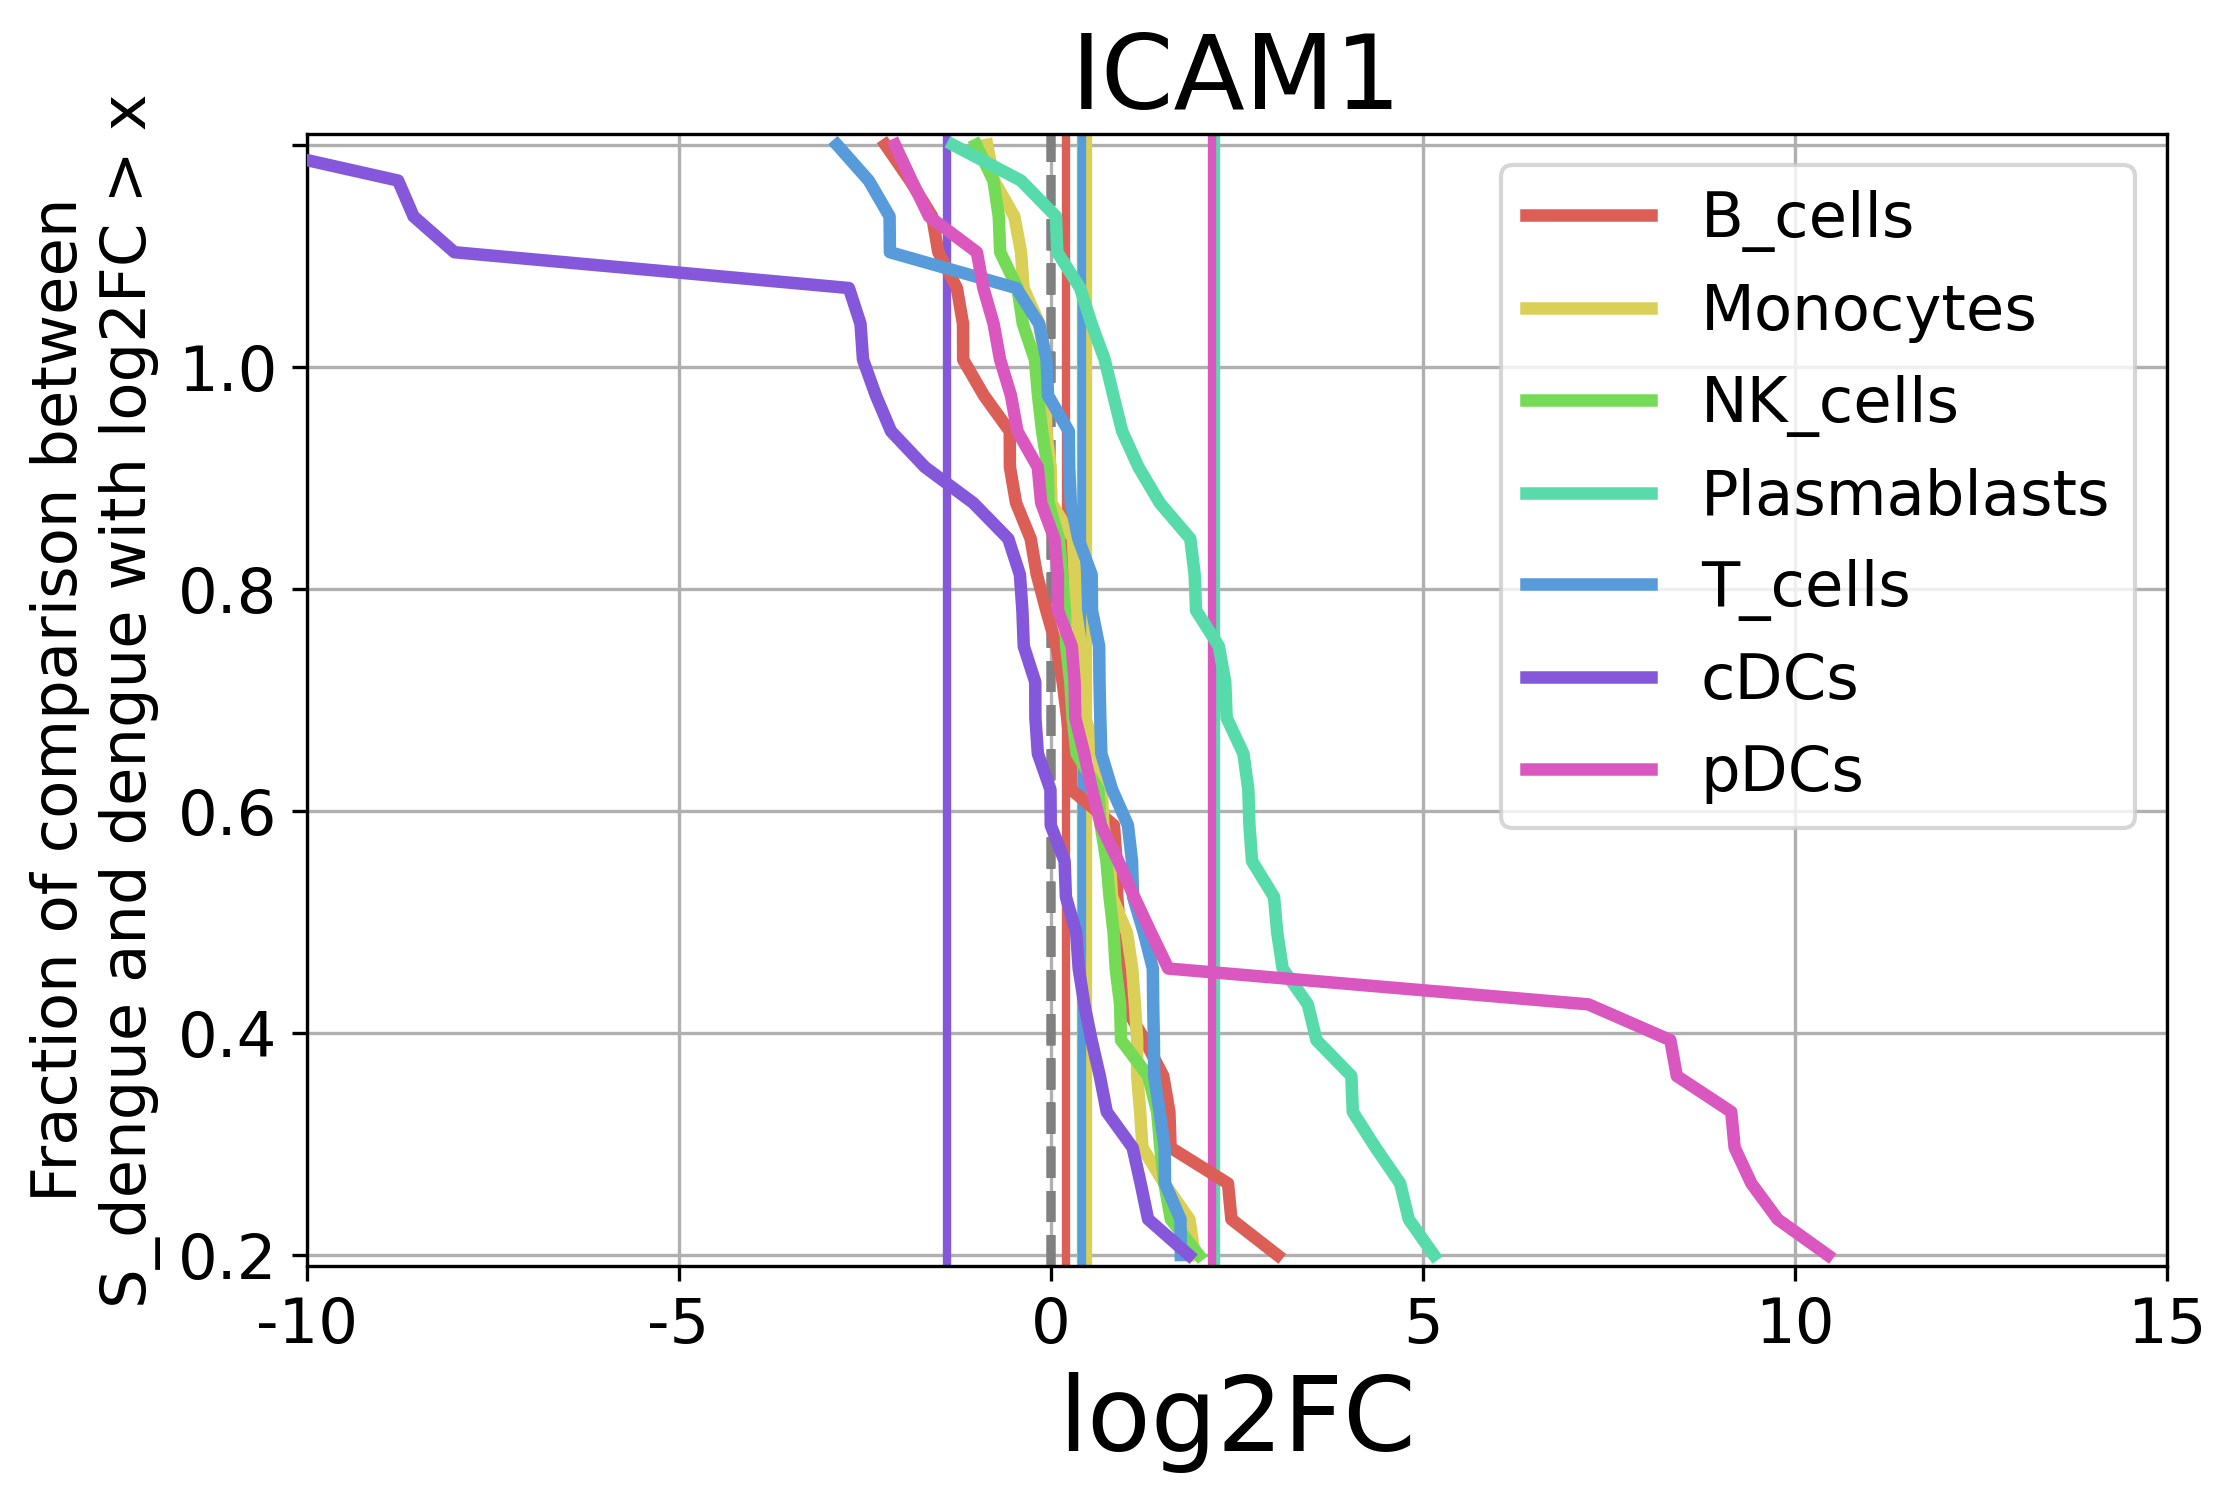

In [24]:
from log2_FC_functions import cul_plot_genes
cul_plot_genes(['ICAM1'], adata, 'S_dengue', 'dengue', 'child', 'cell_type')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


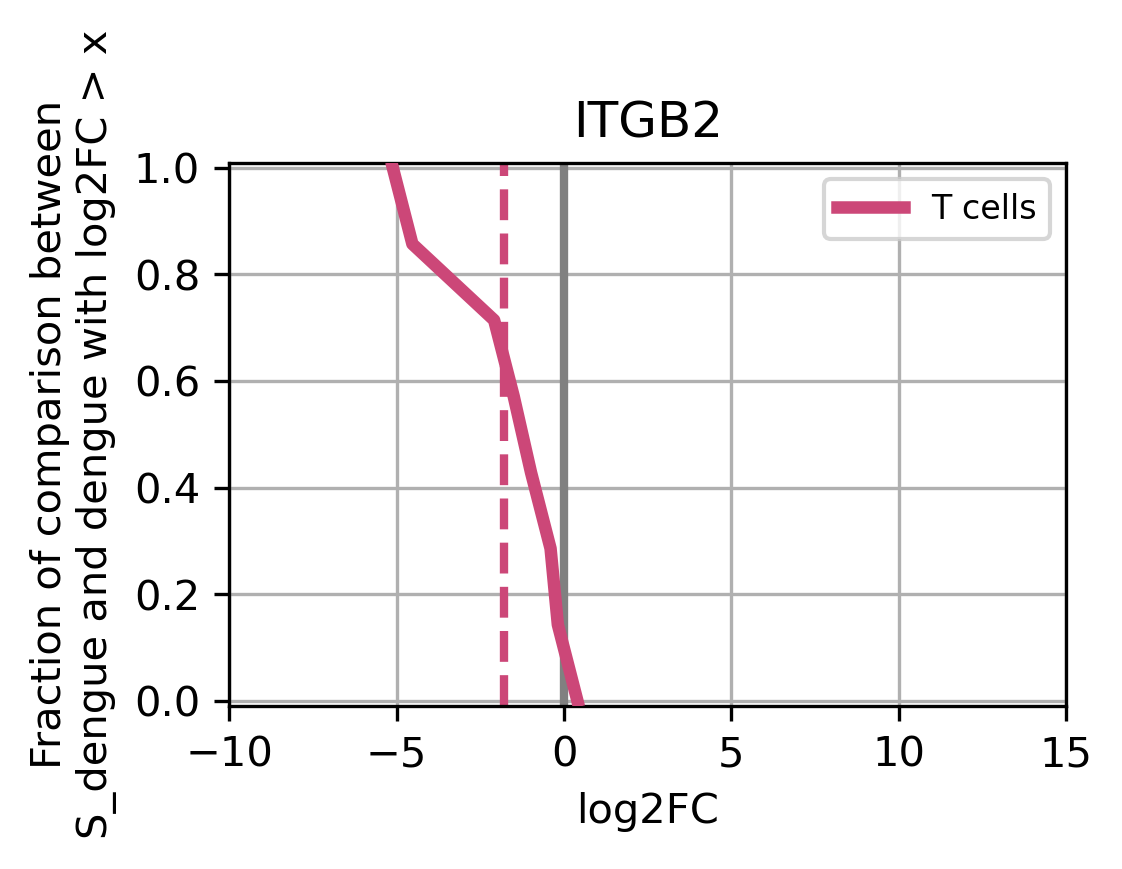

In [28]:
from log2_FC_functions import cul_plot_gene_cts
cul_plot_gene_cts(['ITGB2'], adata, 'S_dengue', 'dengue', 'adult', ['T_cells'])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_ytick

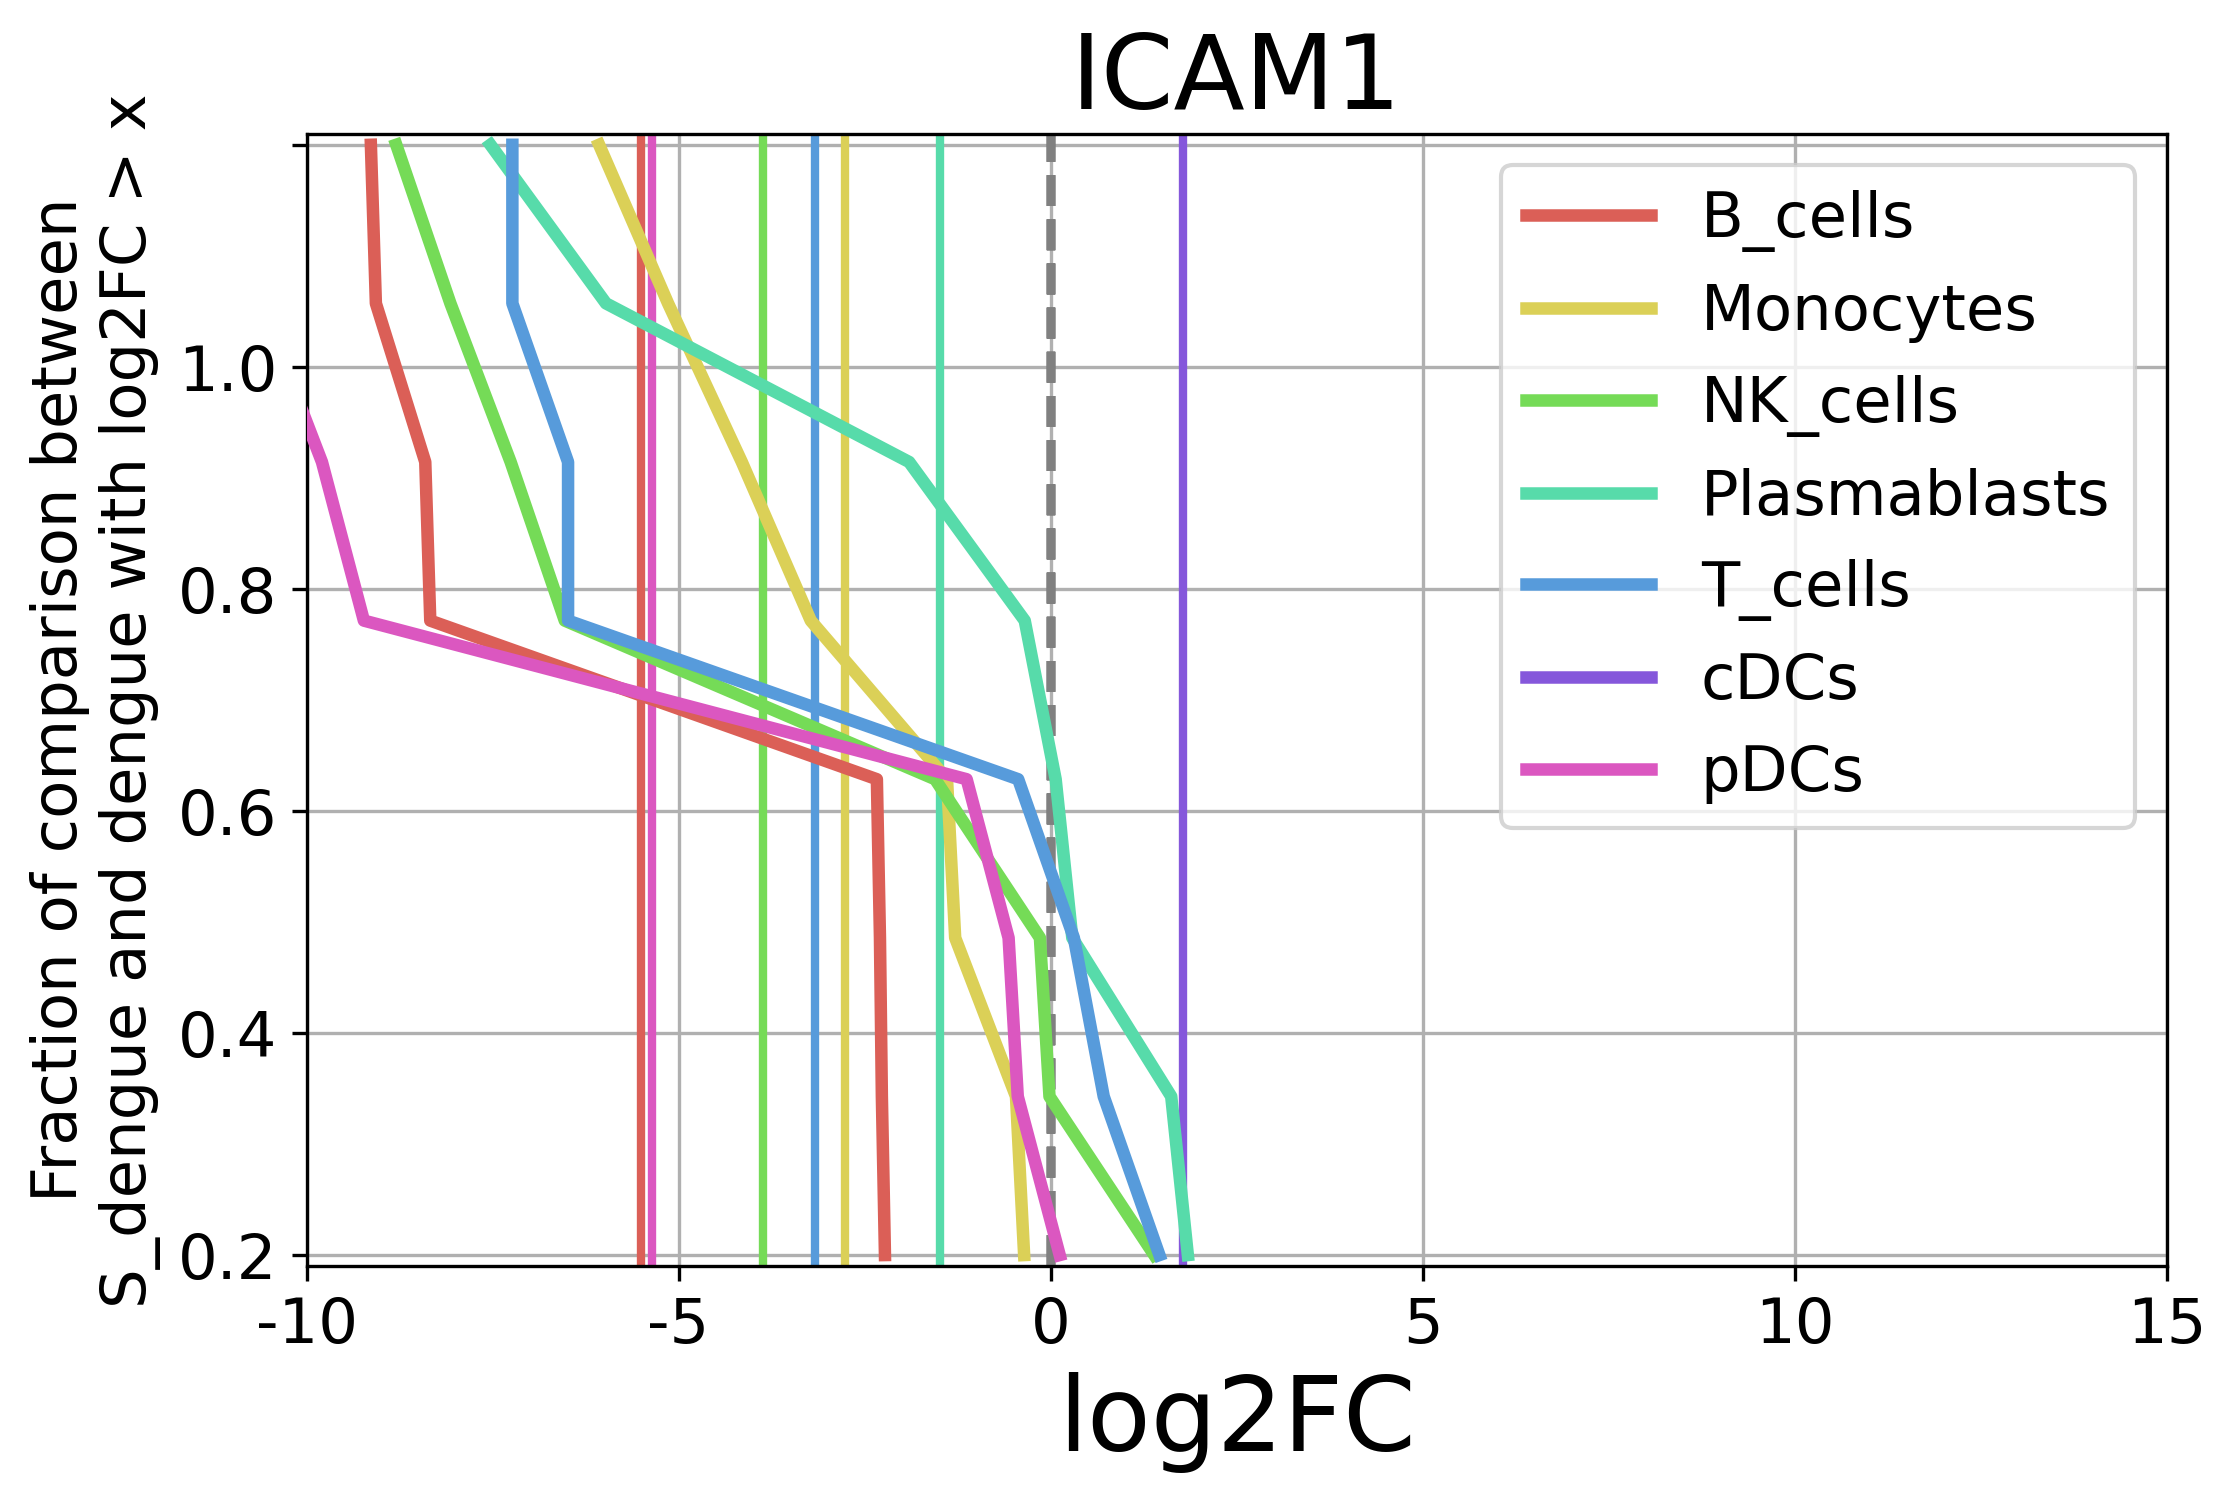

In [26]:
from log2_FC_functions import cul_plot_genes
cul_plot_genes(['ICAM1'], adata, 'S_dengue', 'dengue', 'adult', 'cell_type')

In [5]:
inters_im = defaultdict(list)
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
#conditions = ['S_dengue', 'dengue']

for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    if (ga not in genes) | (gb not in genes):
        continue
    for condition in conditions:
        for ct1 in cell_types:
            for ct2 in cell_types:
                ga_ct1 = gene_exp_ave.loc[(ct1, condition)][gene_exp_ave.loc[(ct1, condition)]['gene'] == ga]['gene_expre'][0]
                gb_ct2 = gene_exp_ave.loc[(ct2, condition)][gene_exp_ave.loc[(ct2, condition)]['gene'] == gb]['gene_expre'][0]
                
                gb_ct1 = gene_exp_ave.loc[(ct1, condition)][gene_exp_ave.loc[(ct1, condition)]['gene'] == gb]['gene_expre'][0]
                ga_ct2 = gene_exp_ave.loc[(ct2, condition)][gene_exp_ave.loc[(ct2, condition)]['gene'] == ga]['gene_expre'][0]

                if (ga_ct1 >= 0.05) & (gb_ct2 >= 0.05):
                    inters_im[(ct1, ct2, condition)].append([ga, gb])
                if (ga_ct2 >= 0.05) & (gb_ct1 >= 0.05):
                    inters_im[(ct1, ct2, condition)].append([gb, ga])
                
for key in inters_im.keys():
    if key[0] == key[1]:
        inters_im[key] = inters_im[key][::2]
        
its = pd.DataFrame([])
for key in inters_im.keys():
    inter_im = pd.DataFrame(inters_im[key], columns=['ga', 'gb'])
    inter_im['cell_type1'] = [key[0]] * len(inters_im[key])
    inter_im['cell_type2'] = [key[1]] * len(inters_im[key])
    inter_im['condition'] = [key[2]] * len(inters_im[key])
    
    its = pd.concat([its, inter_im])

#its.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_cd_005.tsv')

<ipython-input-5-96139f2bdf90>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  ga_ct1 = gene_exp_ave.loc[(ct1, condition)][gene_exp_ave.loc[(ct1, condition)]['gene'] == ga]['gene_expre'][0]
<ipython-input-5-96139f2bdf90>:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  gb_ct2 = gene_exp_ave.loc[(ct2, condition)][gene_exp_ave.loc[(ct2, condition)]['gene'] == gb]['gene_expre'][0]
<ipython-input-5-96139f2bdf90>:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  gb_ct1 = gene_exp_ave.loc[(ct1, condition)][gene_exp_ave.loc[(ct1, condition)]['gene'] == gb]['gene_expre'][0]
<ipython-input-5-96139f2bdf90>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  ga_ct2 = gene_exp_ave.loc[(ct2, condition)][gene_exp_ave.loc[(ct2, condition)]['gene'] == ga]['gene_expre'][0]


In [6]:
inters_im = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_cd_005.tsv', index_col=['cell_type1', 'cell_type2', 'condition'])
intern_im = {}
for key in inters_im.index:
    intern_im[key] = inters_im.loc[key].shape[0]

colors_im = {}
norm_intern_im = {}
for key in intern_im.keys():
    norm_intern_im[key] = (intern_im[(key)] - min(intern_im.values()))/max(intern_im.values())
    colors_im[key] = plt.cm.get_cmap('plasma')(norm_intern_im[key])

<ipython-input-6-50314c582f44>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0]


In [36]:
specific_SD = {}
specific_D = {}
both = {}
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
for ct1 in cell_types:
    for ct2 in cell_types:
        SD_inters = inters_im.loc[(ct1, ct2, 'S_dengue')]
        D_inters = inters_im.loc[(ct1, ct2, 'dengue')]
        SD_pairs = [[ga, gb] for ga, gb in zip(SD_inters['ga'].tolist(), SD_inters['gb'].tolist())]
        D_pairs = [[ga, gb] for ga, gb in zip(D_inters['ga'].tolist(), D_inters['gb'].tolist())]
        specific_SD[ct1, ct2] = [pair for pair in SD_pairs if pair not in D_pairs]
        specific_D[ct1, ct2] = [pair for pair in D_pairs if pair not in SD_pairs]
        both[ct1, ct2] = [pair for pair in D_pairs if pair in SD_pairs]

specific_SD_inters = pd.DataFrame([])
specific_D_inters = pd.DataFrame([])
both_inters = pd.DataFrame([])

for key in specific_SD.keys():
    SD_inter = pd.DataFrame(specific_SD[key], columns=['ga', 'gb'])
    D_inter = pd.DataFrame(specific_D[key], columns=['ga', 'gb'])
    both_inter = pd.DataFrame(both[key], columns=['ga', 'gb'])
    SD_inter['cta'] = [key[0]] * len(specific_SD[key])
    SD_inter['ctb'] = [key[1]] * len(specific_SD[key])
    D_inter['cta'] = [key[0]] * len(specific_D[key])
    D_inter['ctb'] = [key[1]] * len(specific_D[key])
    both_inter['cta'] = [key[0]] * len(both[key])
    both_inter['ctb'] = [key[1]] * len(both[key])

    specific_SD_inters = pd.concat([specific_SD_inters, SD_inter])
    specific_D_inters = pd.concat([specific_D_inters, D_inter])
    both_inters = pd.concat([both_inters, both_inter])
    
specific_SD_inters.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/specific_SD_inters.tsv')
specific_D_inters.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/specific_D_inters.tsv')
both_inters.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/both_inters.tsv')

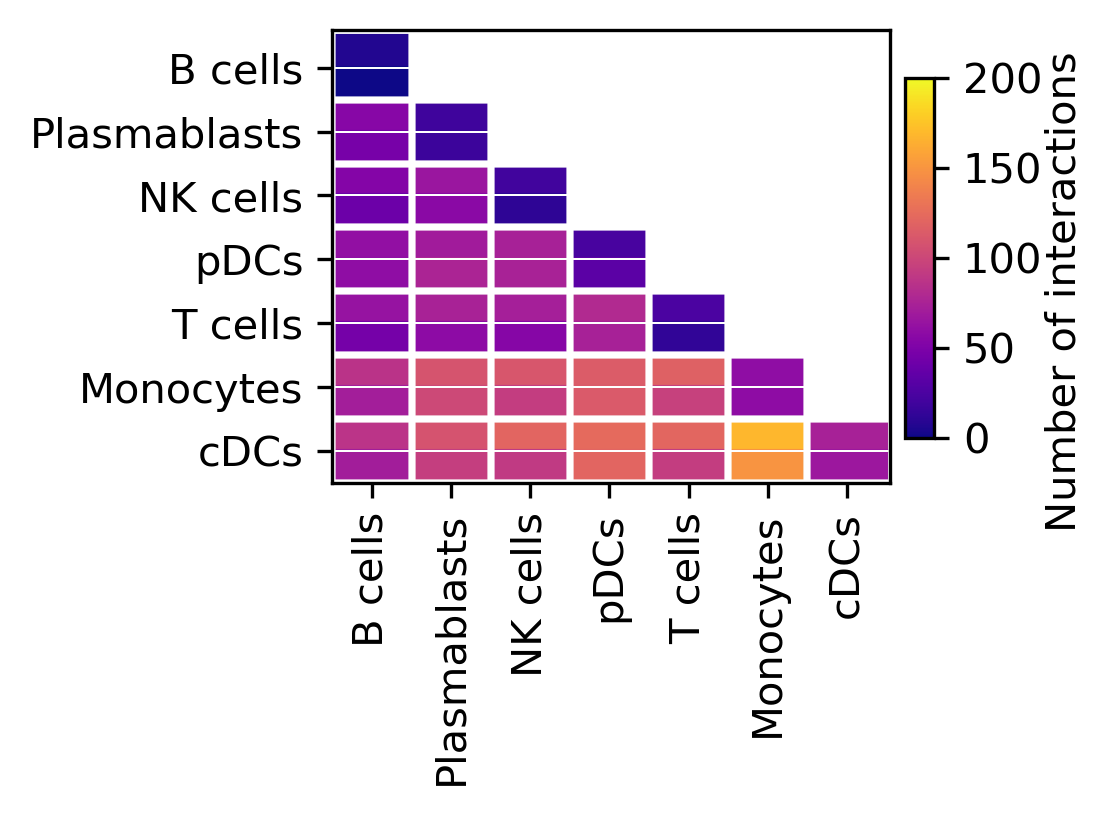

In [48]:
####################################### immune and immune: optimized cell_types, set S_dengue as the example
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

####################################### plot
    
fig, ax = plt.subplots(figsize=[2.4, 2], dpi=300) 

for a in range(len(cts_im_op)):
    for b in range(len(cts_im_op)):
        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
        ax.axhline(b+0.5, c='white', lw=0.4)
        
        if a+b <= 6:
            ######################################## S_dengue, up
            dots1 = [[a, b+0.5],
                    [a+1, b+0.5],
                    [a+1, b+1],
                    [a, b+1],
            ]
            e1 = mpatches.Polygon(np.array(dots1), color=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'S_dengue')])

            ax.add_patch(e1)

            ######################################## dengue, bpttom
            dots2 = [[a, b],
                    [a+1, b],
                    [a+1, b+0.5],
                    [a, b+0.5],
            ]
            e2 = mpatches.Polygon(np.array(dots2), color=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'dengue')])
            ax.add_patch(e2)

    ax.axvline(len(cts_im_op)+1, c='w')
    ax.axhline(len(cts_im_op)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,7.1])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

for i, ct in enumerate(cts_im_op):
        if ct in ['B_cells', 'T_cells', 'NK_cells']:
            cts_im_op[i] = ct.replace('_', ' ')
ax.set_xticklabels(list(reversed(cts_im_op)), rotation=90)
ax.set_yticklabels(cts_im_op)

norm_im = mpl.colors.Normalize(vmin=0, vmax=200) # max(intern_im.values())
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.92, 0.2, 0.04, 0.6]) # [left, bottom, width, height]
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

ax.text(9, 3, 'Number of interactions', verticalalignment='center', rotation=90)

plt.show()

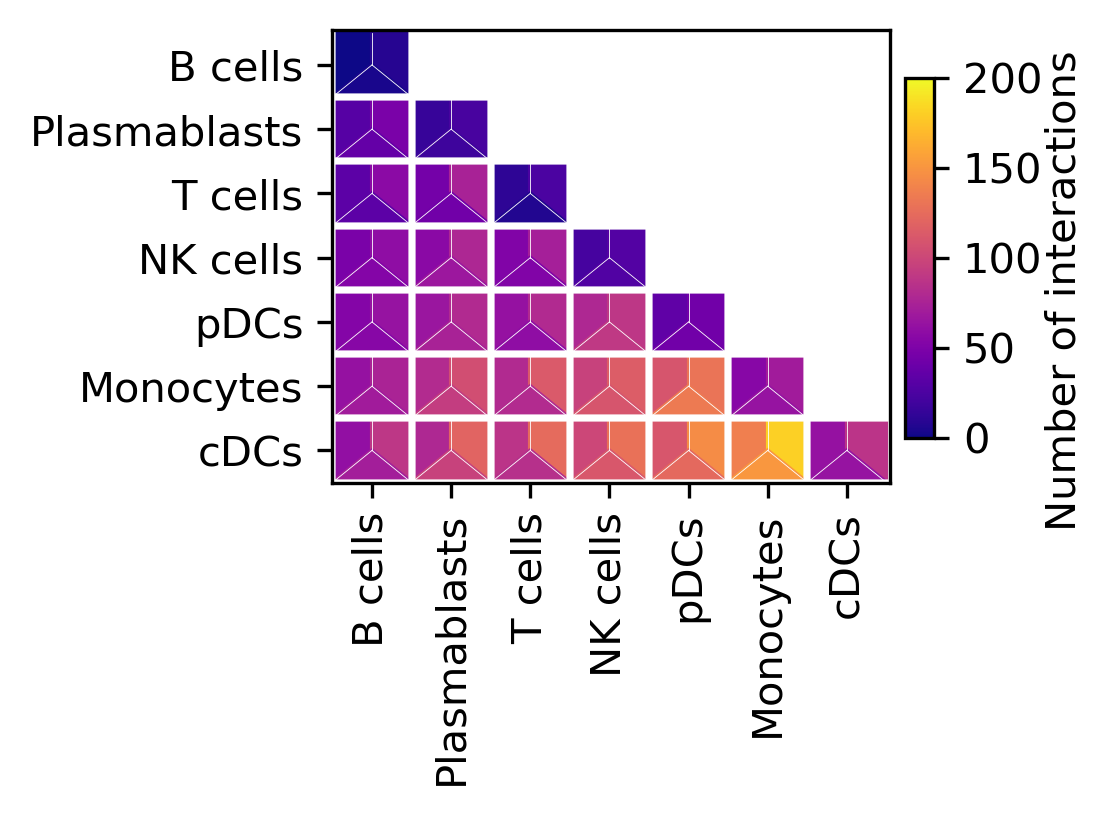

In [39]:
####################################### immune and immune: optimized cell_types, set S_dengue as the example
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

####################################### plot
    
fig, ax = plt.subplots(figsize=[2.4, 2], dpi=300) 

for a in range(len(cts_im_op)):
    for b in range(len(cts_im_op)):
        ax.plot([a, a+0.5], [b, b+0.5], c='white', lw=0.2)
        ax.plot([a+0.5, a+1], [b+0.5, b], c='white', lw=0.2)
        ax.plot([a+0.5, a+0.5], [b+0.5, b+1], c='white', lw=0.2)
        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
        
        if a+b <= 6:
            
            ######################################## dengue, left
            dots1 = [[a, b],
                    [a, b+1],
                    [a+0.5, b+1],
                    [a+0.5, b+.5],
            ]
            e1 = mpatches.Polygon(np.array(dots1), color=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'dengue')])

            ax.add_patch(e1)

            ######################################## S_dengue, right
            dots2 = [[a+0.5, b+.5],
                    [a+0.5, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e2 = mpatches.Polygon(np.array(dots2), color=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'S_dengue')])
            ax.add_patch(e2)

            ######################################## Healthy, bottom
            dots3 = [[a+0.5, b+.5],
                    [a, b],
                    [a+1, b],
            ]
            e3 = mpatches.Polygon(np.array(dots3), color=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'Healthy')])
            ax.add_patch(e3)

    ax.axvline(len(cts_im_op)+1, c='w')
    ax.axhline(len(cts_im_op)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,7.05])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

for i, ct in enumerate(cts_im_op):
        if ct in ['B_cells', 'T_cells', 'NK_cells']:
            cts_im_op[i] = ct.replace('_', ' ')
ax.set_xticklabels(list(reversed(cts_im_op)), rotation=90)
ax.set_yticklabels(cts_im_op)

norm_im = mpl.colors.Normalize(vmin=0, vmax=200) # max(intern_im.values())
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.92, 0.2, 0.04, 0.6]) # [left, bottom, width, height]
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

ax.text(9, 3, 'Number of interactions', verticalalignment='center', rotation=90)

plt.show()

In [ ]:
### calculate the number of interactions between immune cells and endothelial cells (Kyle's dataset), expression > 10 %

adata_human_lung = sc.read_h5ad('/home/yike/phd/dengue/data/dataset_from_google/human_lung/human/human_lung_10X.h5ad')
adata_hl_endo = adata_human_lung[adata_human_lung.obs['compartment'] == 'Endothelial']

# matching = [s for s in adata_hl_endo.var.index if 'REF' in s]
genes_endo = np.setdiff1d(genes, np.array(['ERFE', 'NECTIN1', 'NECTIN2', 'NECTIN3', 'NECTIN4', 'VEGFD', 'VSIR']))
adata_hl_g = adata_hl_endo[:, genes_endo]

from collections import defaultdict

################################################# gene expression in immune cells at three conditions
adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']

adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

gene_exp_im = {}
for key in adatag_ch_ct_cd.keys():
    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    gene_exp_im[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

################################################### gene expression in endothelial cells
endo_cts = list(adata_hl_g.obs.free_annotation.value_counts().index) #### need to remove cell types special for lung in next cell

adata_hl_dic = {}
for ct in endo_cts:
    adata_hl_dic[ct] = adata_hl_g[adata_hl_g.obs.free_annotation == ct]

gene_exp_ed = {}
for key in adata_hl_dic.keys():
    exp = (adata_hl_dic[key].X > 0).toarray().mean(axis=0)
    gene_exp_ed[key] = pd.DataFrame(exp, index=adata_hl_dic[key].var.index, columns=[['gene_expre']])

inters_ed = defaultdict(list)
for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    for condition in conditions:
        for ct1 in cell_types:
            for ct2 in endo_cts:
                if ga not in genes_endo:
                    pass
                elif gb not in genes_endo:
                    pass
                else:
                    if (gene_exp_im[(ct1, condition)].loc[ga][0] > 0.1) & (gene_exp_ed[ct2].loc[gb][0] > 0.1):
                        inters_ed[(ct1, ct2, condition)].append([ga, gb])
                    elif (gene_exp_im[(ct1, condition)].loc[gb][0] > 0.1) & (gene_exp_ed[ct2].loc[ga][0] > 0.1):
                        inters_ed[(ct1, ct2, condition)].append([gb, ga])
                    else:
                        pass

intern_ed = {}
for key in inters_ed.keys():
    intern_ed[key] = len(inters_ed[key])

colors_ed = {}
norm_intern_ed = {}
for key in intern_ed.keys():
    norm_intern_ed[key] = (intern_ed[(key)] - min(intern_ed.values()))/max(intern_ed.values())
    colors_ed[key] = plt.cm.get_cmap('plasma')(norm_intern_ed[key])

# min(intern.values())   103
# max(intern.values())   405

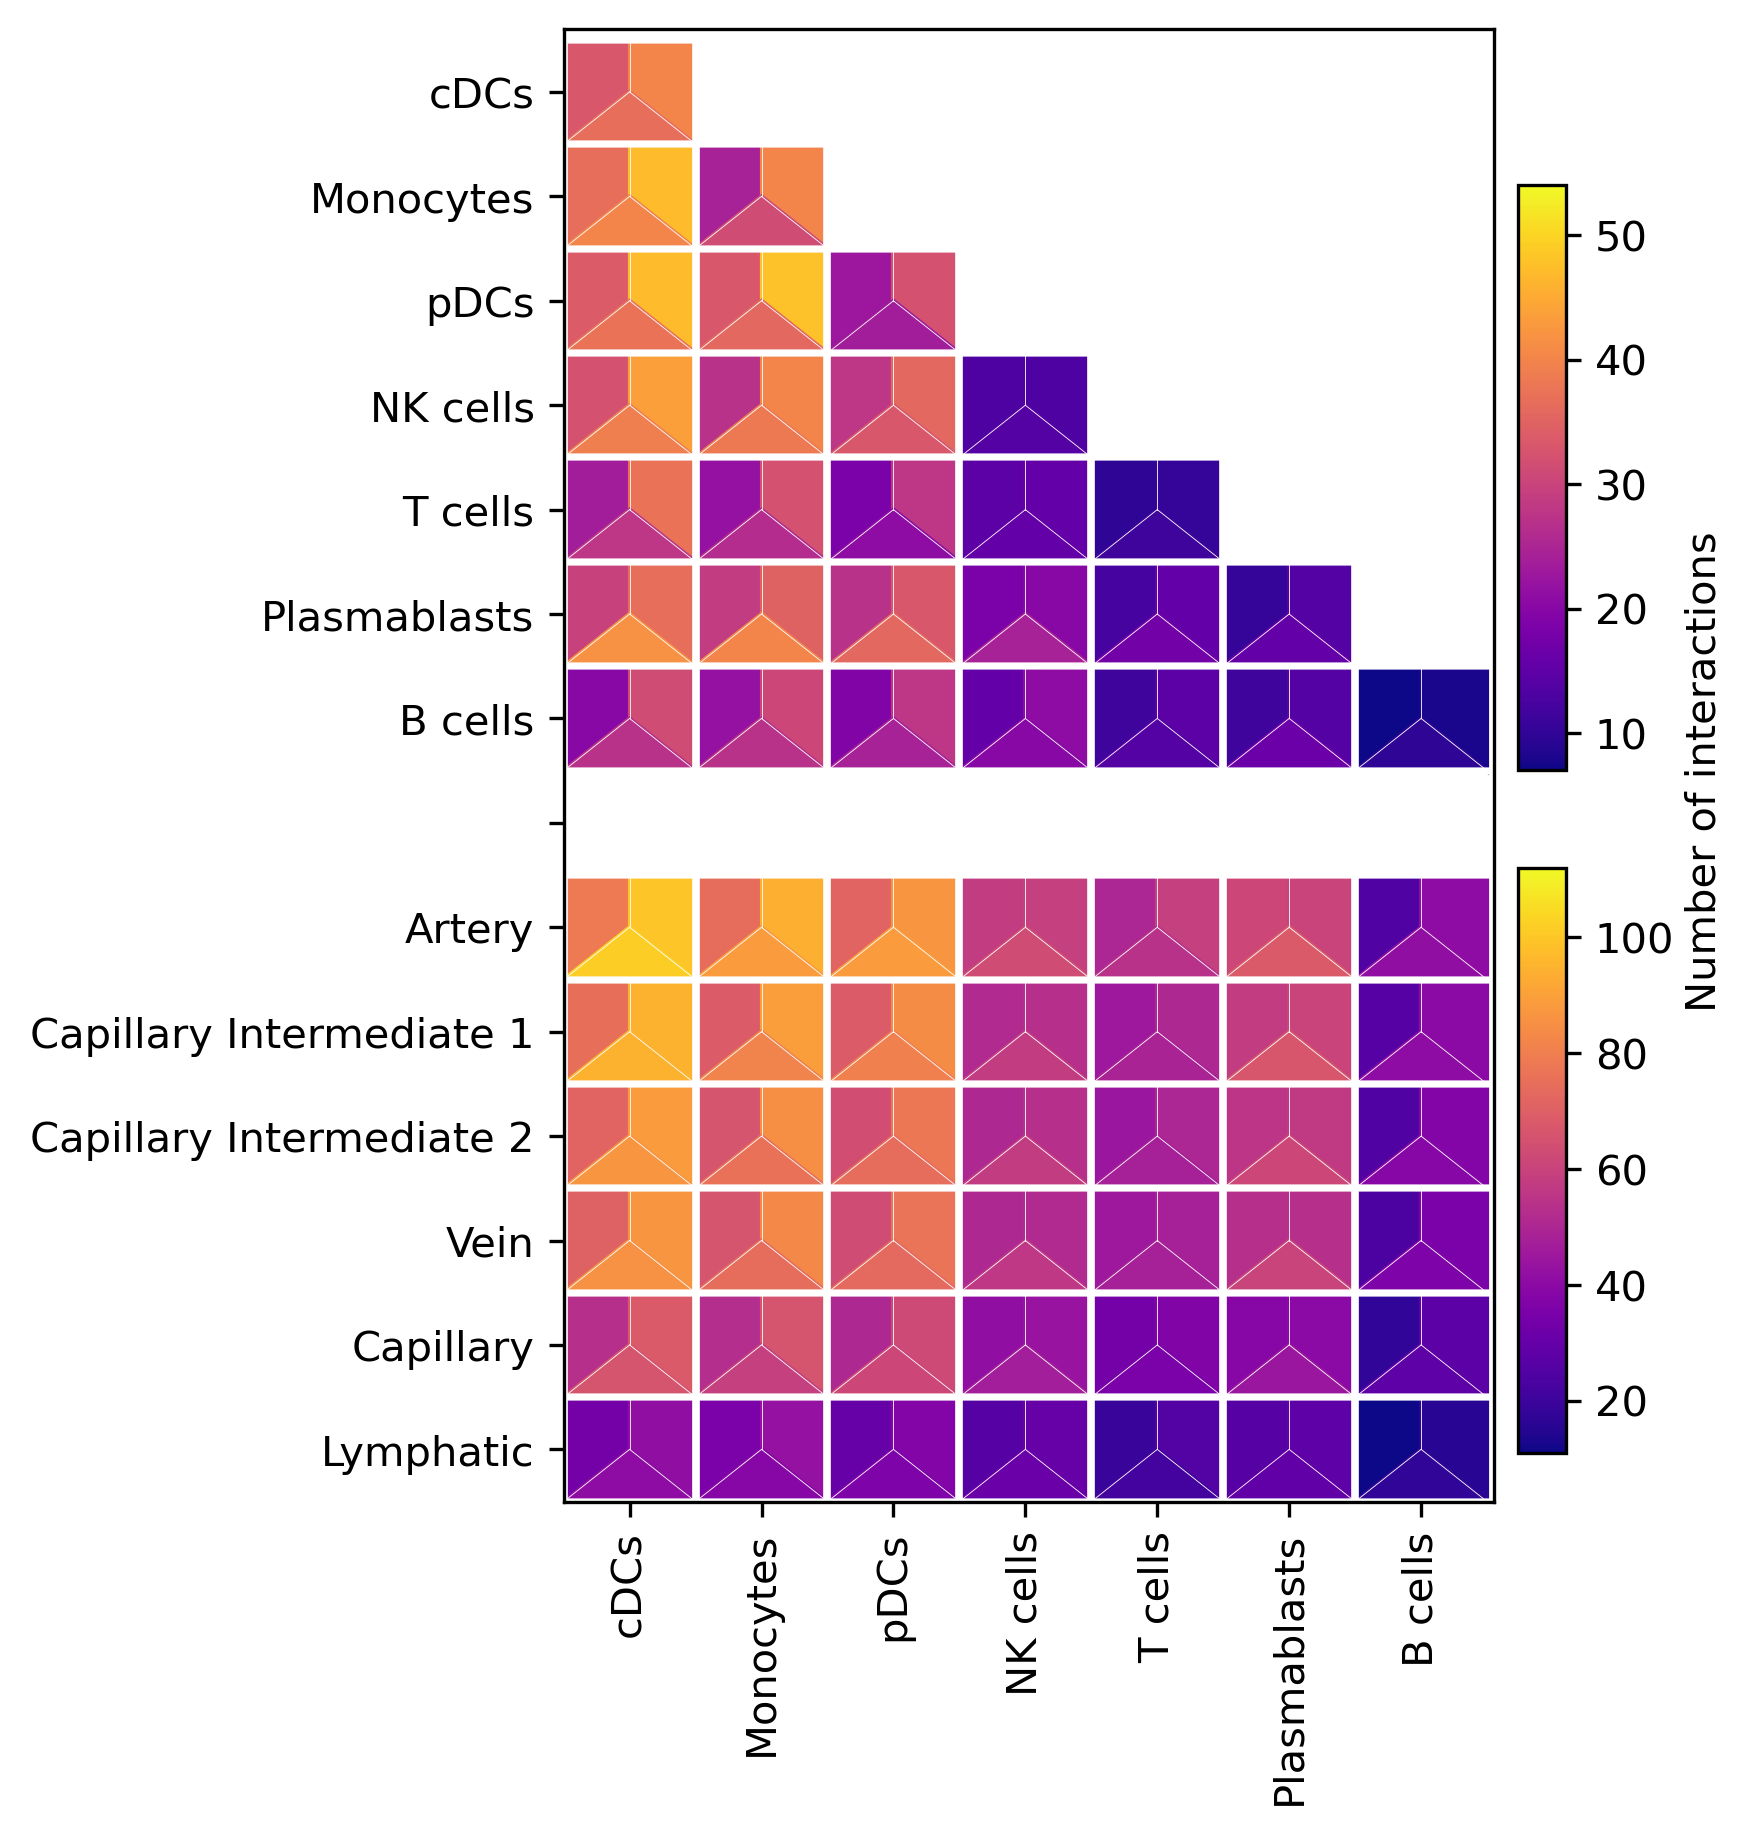

In [100]:
####################################### immune and immune: optimized cell_types, set S_dengue as the example
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

####################################### immune and endo: optimized cell_types, set S_dengue as the example
it_ed = pd.DataFrame([])
ls_ed = defaultdict(list)

### remove the cell types special for lung from endo_cts
# 'Capillary Aerocyte': alveolar type I capillaries
# 'Bronchial Vessel 1', 'Bronchial Vessel 2'
# 'Capillary Intermediate': precapillaries
ed_cts = ['Artery', 'Capillary', 'Vein', 'Capillary Intermediate 1', 'Capillary Intermediate 2', 'Lymphatic']

for a in range(len(cts_im_op)):
    for b in range(len(ed_cts)):
        ls_ed[cts_im_op[a]].append(intern_ed[(cts_im_op[a], ed_cts[b], 'S_dengue')])
    it_ed[cts_im_op[a]] = ls_ed[cts_im_op[a]]
    
it_ed.index = pd.Index(ed_cts)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_ed.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_ed = leaves_list(lkg) 

it_ed_new = it_ed.iloc[best_order_ed]
cts_ed_op = list(it_ed_new.index)

####################################### plot
colors_ed2 = {}
norm_intern_ed2 = {}
for key in intern_ed.keys():
    norm_intern_ed2[key] = (intern_ed[(key)] - min(intern_ed.values()))/max(intern_ed.values())
    colors_ed2[key] = plt.cm.get_cmap('plasma')(norm_intern_ed2[key])

colors_im2 = {}
norm_intern_im2 = {}
for key in intern_im.keys():
    norm_intern_im2[key] = (intern_im[(key)] - min(intern_im.values()))/max(intern_im.values())
    colors_im2[key] = plt.cm.get_cmap('plasma')(norm_intern_im2[key])
    
fig, ax = plt.subplots(figsize=[4, 6.5], dpi=300) 

cts = cts_ed_op + cts_im_op

for a in range(len(cts_im_op)):
    for b in range(len(cts)+1):
        ax.plot([a, a+0.5], [b, b+0.5], c='white', lw=0.2)
        ax.plot([a+0.5, a+1], [b+0.5, b], c='white', lw=0.2)
        ax.plot([a+0.5, a+0.5], [b+0.5, b+1], c='white', lw=0.2)
        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
        
        if b < len(cts_ed_op):  ##############################  immune & endo 
            ######################################## dengue, left
            dots4 = [[a, b],
                    [a, b+1],
                    [a+0.5, b+1],
                    [a+0.5, b+0.5],
            ]
            e4 = mpatches.Polygon(np.array(dots4), color=colors_ed2[(list(reversed(cts_im_op))[a], cts[b], 'dengue')])
            ax.add_patch(e4)

            ######################################## S_dengue, right
            dots5 = [[a+0.5, b+0.5],
                    [a+0.5, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e5 = mpatches.Polygon(np.array(dots5), color=colors_ed2[(list(reversed(cts_im_op))[a], cts[b], 'S_dengue')])
            ax.add_patch(e5)

            ######################################## Healthy, bottom
            dots6 = [[a+0.5, b+0.5],
                    [a, b],
                    [a+1, b],
            ]
            e6 = mpatches.Polygon(np.array(dots6), color=colors_ed2[(list(reversed(cts_im_op))[a], cts[b], 'Healthy')])
            ax.add_patch(e6)
                 
        else: ##############################  immune & immune 
            if len(cts_im_op)-1-a >= b-len(cts_ed_op):
                ######################################## dengue, left
                dots1 = [[a, b+1],
                        [a, b+2],
                        [a+0.5, b+2],
                        [a+0.5, b+1.5],
                ]
                e1 = mpatches.Polygon(np.array(dots1), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'dengue')])

                #patches.append(e1)
        #collection = PatchCollection(patches, color= colors)
        #ax.add_collection(collection)
                ax.add_patch(e1)

                ######################################## S_dengue, right
                dots2 = [[a+0.5, b+1.5],
                        [a+0.5, b+2],
                        [a+1, b+2],
                        [a+1, b+1],
                ]
                e2 = mpatches.Polygon(np.array(dots2), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'S_dengue')])
                ax.add_patch(e2)

                ######################################## Healthy, bottom
                dots3 = [[a+0.5, b+1.5],
                        [a, b+1],
                        [a+1, b+1],
                ]
                e3 = mpatches.Polygon(np.array(dots3), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'Healthy')])
                ax.add_patch(e3)
            else:
                pass

    ax.axvline(len(cts_im_op)+1, c='w')
    ax.axhline(len(cts_ed_op)+len(cts_im_op)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,14.1])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5])
ax.set_xticklabels(list(reversed(['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'pDCs', 'Monocytes', 'cDCs'])), rotation=90)
ax.set_yticklabels(cts_ed_op + ['', 'B cells', 'Plasmablasts', 'T cells', 'NK cells', 'pDCs', 'Monocytes', 'cDCs'])

norm_ed = mpl.colors.Normalize(vmin=min(intern_ed.values()), vmax=max(intern_ed.values()))
cmap_ed = plt.cm.get_cmap('plasma')
position_ed = fig.add_axes([0.92, 0.15, 0.04, 0.3]) # [left, bottom, width, top]
cbar_ed = plt.colorbar(plt.cm.ScalarMappable(norm=norm_ed, cmap=cmap_ed), cax=position_ed, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

norm_im = mpl.colors.Normalize(vmin=min(intern_im.values()), vmax=max(intern_im.values()))
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.92, 0.5, 0.04, 0.3]) # [left, bottom, width, height]
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

ax.text(8.5, 7, 'Number of interactions', verticalalignment='center', rotation=90)

plt.show()

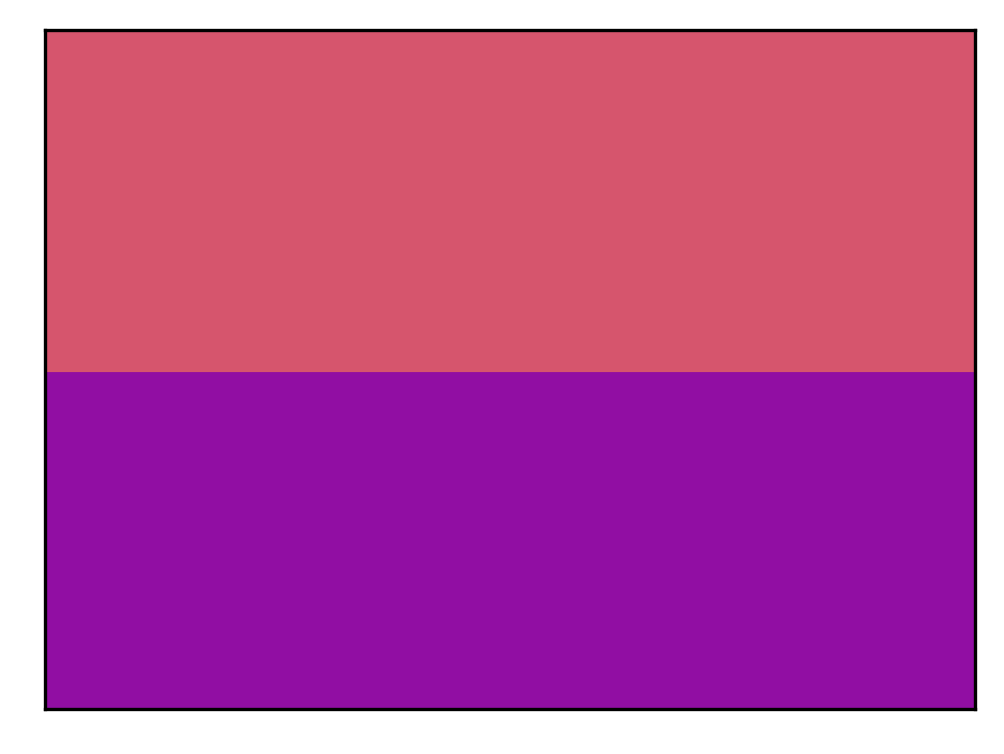

In [56]:
fig, ax = plt.subplots(dpi=300, figsize=[4, 3])
######################################## dengue, left
dots1 = [[0, 0],
        [0, 0.5],
        [1, 0.5],
        [1, 0],
]
e1 = mpatches.Polygon(np.array(dots1), color=colors_im[list(colors_im.keys())[-1]])
ax.add_patch(e1)

######################################## S_dengue, right
dots2 = [[0, 0.5],
        [0, 1],
        [1, 1],
        [1, 0.5],
]
e2 = mpatches.Polygon(np.array(dots2), color=colors_im[list(colors_im.keys())[0]])
ax.add_patch(e2)

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

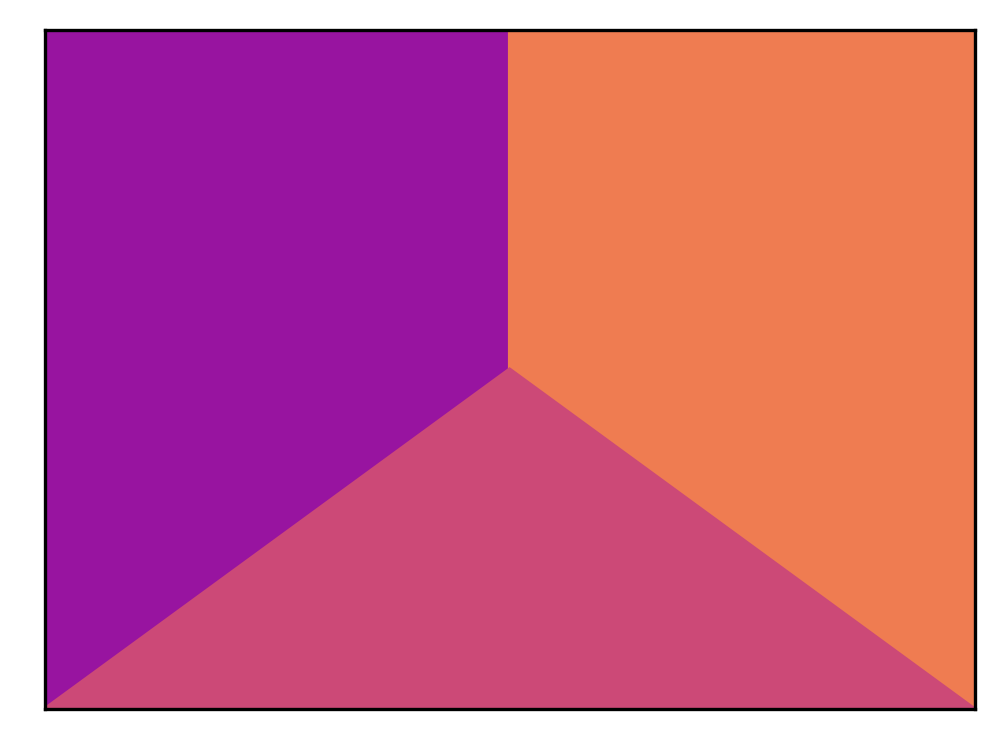

In [121]:
fig, ax = plt.subplots(dpi=300, figsize=[4, 3])
######################################## dengue, left
dots1 = [[0, 0],
        [0, 1],
        [0.5, 1],
        [0.5, 0.5],
]
e1 = mpatches.Polygon(np.array(dots1), color=colors[list(colors.keys())[0]])

#patches.append(e1)
#collection = PatchCollection(patches, color= colors)
#ax.add_collection(collection)
ax.add_patch(e1)

######################################## S_dengue, right
dots2 = [[0.5, 0.5],
        [0.5, 1],
        [1, 1],
        [1, 0],
]
e2 = mpatches.Polygon(np.array(dots2), color=colors[list(colors.keys())[1]])
ax.add_patch(e2)

######################################## Healthy, bottom
dots3 = [[0.5, 0.5],
        [0, 0],
        [1, 0],
]
e3 = mpatches.Polygon(np.array(dots3), color=colors[list(colors.keys())[2]])
ax.add_patch(e3)
    
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [4]:
# interactions with the log2_FC (S_dengue vs dengue) of ligand and receptor both up (top 50) or down (bottom 50)

log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=0)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
both_up = defaultdict(list)
both_down = defaultdict(list)

for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    for ct1 in cell_types:
        for ct2 in cell_types:
            ga_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == ga]['fold_2_change'][0]
            ga_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == ga]['fold_2_change'][0]
            gb_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == gb]['fold_2_change'][0]
            gb_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == gb]['fold_2_change'][0]
            
            if ct1 != ct2:
                if (ga in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                if (ga in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
            else:
                if (ga in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                elif (gb in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                elif (ga in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                elif (gb in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                    
                    
inter_up = pd.DataFrame([])
inter_down = pd.DataFrame([])

for key in both_up.keys():
    up = pd.DataFrame(both_up[key], columns=['ga', 'log2_FC_ga', 'gb', 'log2_FC_gb'], index=pd.Index([key[0]+' '+key[1]]*len(both_up[key])))
    down = pd.DataFrame(both_down[key], columns=['ga', 'log2_FC_ga', 'gb', 'log2_FC_gb'], index=pd.Index([key[0]+' '+key[1]]*len(both_down[key])))
    inter_up = pd.concat([inter_up, up])
    inter_down = pd.concat([inter_down, down])      

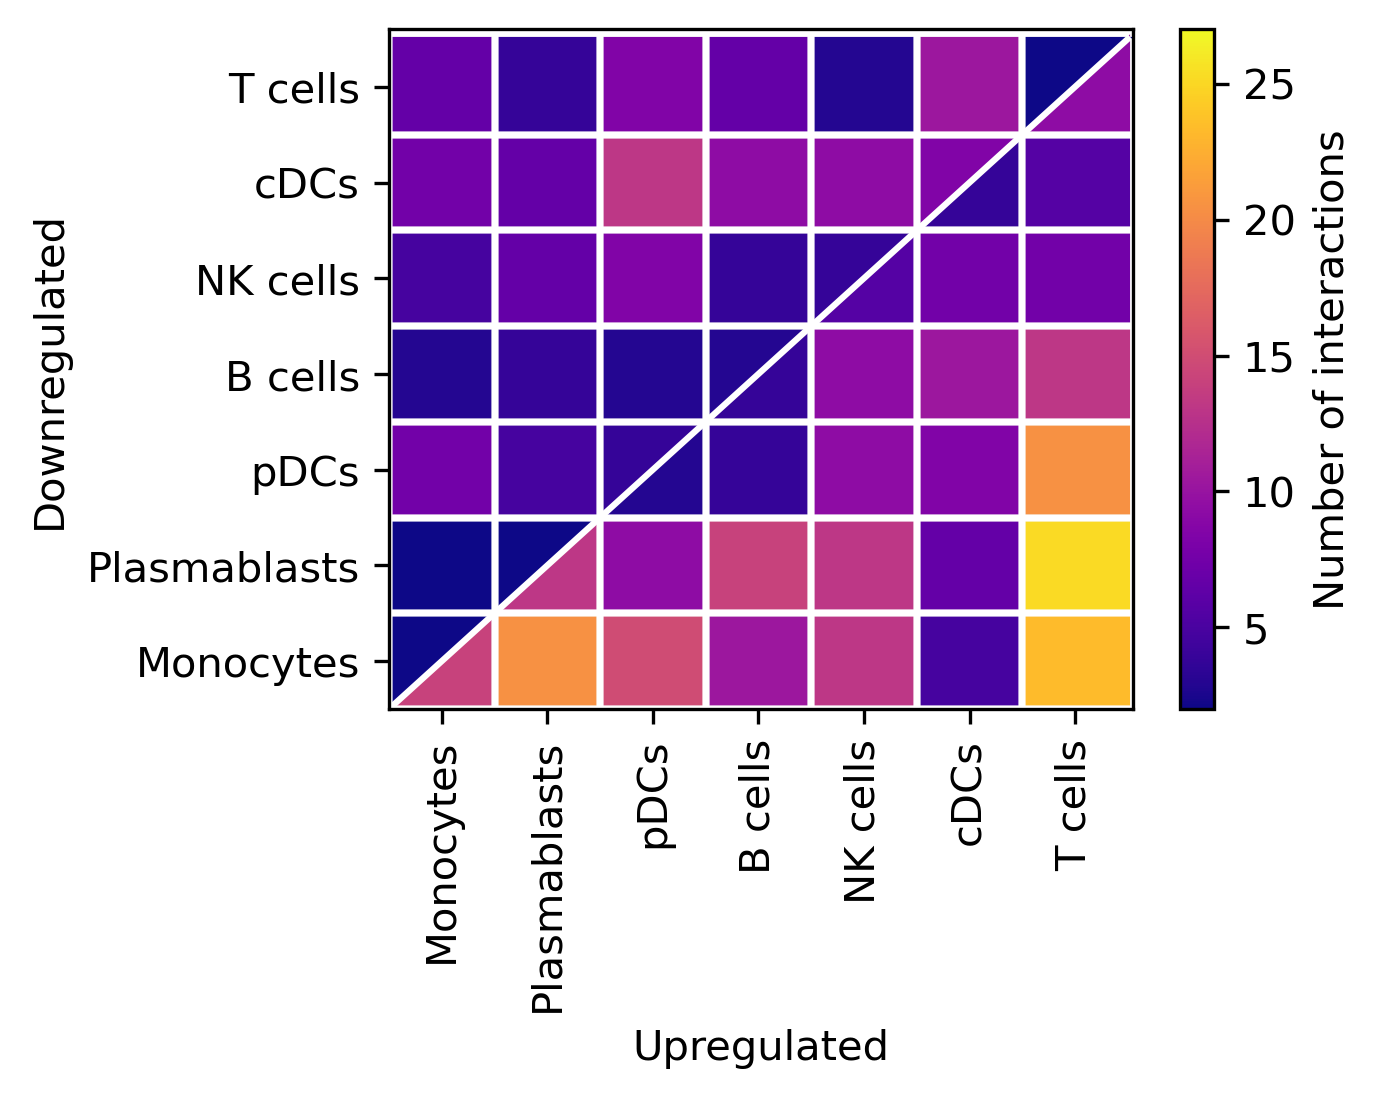

In [19]:
# up and down regulated
############################################## define dic of number of interactions
intern_up = {}
for key in both_up.keys():
    intern_up[key] = len(both_up[key])

intern_down = {}
for key in both_down.keys():
    intern_down[key] = len(both_down[key])    
    
colors_up = {}
norm_intern_up = {}
for key in intern_up.keys():
    norm_intern_up[key] = (intern_up[(key)] - min(intern_down.values()))/max(intern_up.values()) ####
    colors_up[key] = plt.cm.get_cmap('plasma')(norm_intern_up[key])

colors_down = {}
norm_intern_down = {}
for key in intern_down.keys():
    norm_intern_down[key] = (intern_down[(key)] - min(intern_down.values()))/max(intern_up.values()) ####
    colors_down[key] = plt.cm.get_cmap('plasma')(norm_intern_down[key])

############################################## optimize sequence of cell types
it = pd.DataFrame([])
ls = defaultdict(list)

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        if b <= a:
            ls[cell_types[a]].append(intern_up[(cell_types[a], cell_types[b])])
        else:
            ls[cell_types[a]].append(intern_down[(cell_types[a], cell_types[b])])
    it[cell_types[a]] = ls[cell_types[a]]
    
it.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order = leaves_list(lkg) 

it_new = it.iloc[best_order]

############################################## plot
fig, ax = plt.subplots(dpi=300, figsize=[4, 3])
op_cts = list(it_new.index)

for a in range(len(op_cts)):
    for b in range(len(op_cts)): 
        if a > b:
            dots = [[a, b],
                    [a, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e = mpatches.Polygon(np.array(dots), color=colors_up[(op_cts[a], op_cts[b])])
            ax.add_patch(e)

        elif a == b:
            dots1 = [[a, b],
                    [a+1, b],
                    [a+1, b+1],
            ]
            e1= mpatches.Polygon(np.array(dots1), color=colors_up[(op_cts[a], op_cts[b])])
            ax.add_patch(e1)
            
            dots2 = [[a, b],
                    [a, b+1],
                    [a+1, b+1],
            ]
            e2 = mpatches.Polygon(np.array(dots2), color=colors_down[(op_cts[a], op_cts[b])])
            ax.add_patch(e2)
        
        else:
            dots3 = [[a, b],
                    [a, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e3 = mpatches.Polygon(np.array(dots3), color=colors_down[(op_cts[a], op_cts[b])])
            ax.add_patch(e3)

        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
ax.plot([0, 7], [0,7], c='w')
ax.axvline(len(cell_types)+1, c='w')
ax.axhline(len(cell_types)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,7.1])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(['Monocytes', 'Plasmablasts', 'pDCs', 'B cells', 'NK cells',  'cDCs', 'T cells'], rotation=90)
ax.set_yticklabels(['Monocytes', 'Plasmablasts', 'pDCs', 'B cells', 'NK cells',  'cDCs', 'T cells'])
ax.set_xlabel('Upregulated')
ax.set_ylabel('Downregulated')
#plt.title('Number of interactions', fontsize=10)

norm = mpl.colors.Normalize(vmin=min(intern_down.values()), vmax=max(intern_up.values()))
cmap = plt.cm.get_cmap('plasma')
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Number of interactions')

plt.show()

In [97]:
# define a function to collect interactions meeting both log2_FC and exp fraction

def log2FC_n_fraction(genes, frac_n):
    ####################################### interactions both up --> head(50), both down --> tail(50)
    log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=0)

    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    both_up = defaultdict(list)
    both_down = defaultdict(list)

    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        if (ga not in genes) | (gb not in genes):
            continue
        for ct1 in cell_types:
            for ct2 in cell_types:
                ga_ct1_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == ga]['fold_2_change'][0]
                ga_ct2_log2FC = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == ga]['fold_2_change'][0]
                gb_ct1_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == gb]['fold_2_change'][0]
                gb_ct2_log2FC = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == gb]['fold_2_change'][0]

                ga_ct1_comfrac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == ga]['comp_frac'][0]
                ga_ct2_comfrac = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == ga]['comp_frac'][0]
                gb_ct1_comfrac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == gb]['comp_frac'][0]
                gb_ct2_comfrac = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == gb]['comp_frac'][0]
                
                #ct1_head = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
                #ct2_head = log2_fc_ave.loc[ct2].head(log2FC_n)['gene'].tolist()
                #ct1_tail = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()
                #ct2_tail = log2_fc_ave.loc[ct2].tail(log2FC_n)['gene'].tolist()
                
                ct1_head = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['fold_2_change'] > 0]['gene'].tolist()
                ct2_head = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['fold_2_change'] > 0]['gene'].tolist()
                ct1_tail = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['fold_2_change'] < 0]['gene'].tolist()
                ct2_tail = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['fold_2_change'] < 0]['gene'].tolist()
                
                #ct1_head = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] >= comp_frac]['gene'].tolist()
                #ct2_head = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['comp_frac'] >= comp_frac]['gene'].tolist()
                #ct1_tail = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] <= 1-comp_frac]['gene'].tolist()
                #ct2_tail = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['comp_frac'] <= 1-comp_frac]['gene'].tolist()

                if (ga in ct1_head) & (gb in ct2_head):
                    both_up[(ct1, ct2)].append([ga, ga_ct1_log2FC, ga_ct1_comfrac, gb, gb_ct2_log2FC, gb_ct2_comfrac])
                if (gb in ct1_head) & (ga in ct2_head):
                    both_up[(ct1, ct2)].append([gb, gb_ct1_log2FC, gb_ct1_comfrac, ga, ga_ct2_log2FC, ga_ct2_comfrac])
                if (ga in ct1_tail) & (gb in ct2_tail):
                    both_down[(ct1, ct2)].append([ga, ga_ct1_log2FC, ga_ct1_comfrac, gb, gb_ct2_log2FC, gb_ct2_comfrac])
                if (gb in ct1_tail) & (ga in ct2_tail):
                    both_down[(ct1, ct2)].append([gb, gb_ct1_log2FC, gb_ct1_comfrac, ga, ga_ct2_log2FC, ga_ct2_comfrac])
    
    ####################################### both log2_FC and exp fraction
    # log2_FC in head(50), exp fraction >= 5 % in S_dengue
    # log2_FC in tail(50), exp fraction >= 5 % in dengue
    inter_final = defaultdict(list)

    for dic, cd, k in zip([both_up, both_down], ['S_dengue', 'dengue'], ['up', 'down']):
        for key in dic.keys(): # eg., both_up[(ct1, ct2)]
            for a in range(len(dic[key])): # eg., [ga, ga_ct1_log2FC, ga_ct1_comfrac, gb, gb_ct2_log2FC, gb_ct2_comfrac]
                ga = dic[key][a][0] # in cell type --> key[0]
                gb = dic[key][a][3] # in cell type --> key[1]
                
                ga_in_ct1 = gene_exp_ave.loc[(key[0], cd)][gene_exp_ave.loc[(key[0], cd)]['gene'] == ga]['gene_expre'][0]
                gb_in_ct2 = gene_exp_ave.loc[(key[1], cd)][gene_exp_ave.loc[(key[1], cd)]['gene'] == gb]['gene_expre'][0]
                #############################################
                if cd == 'S_dengue':
                    ga_SD_exp_frac = ga_in_ct1
                    ga_D_exp_frac = gene_exp_ave.loc[(key[0], 'dengue')][gene_exp_ave.loc[(key[0], 'dengue')]['gene'] == ga]['gene_expre'][0]
                    gb_SD_exp_frac = gb_in_ct2
                    gb_D_exp_frac = gene_exp_ave.loc[(key[1], 'dengue')][gene_exp_ave.loc[(key[1], 'dengue')]['gene'] == gb]['gene_expre'][0]
                else:
                    ga_SD_exp_frac = gene_exp_ave.loc[(key[0], 'S_dengue')][gene_exp_ave.loc[(key[0], 'S_dengue')]['gene'] == ga]['gene_expre'][0]
                    ga_D_exp_frac = ga_in_ct1
                    ga_SD_exp_frac = gene_exp_ave.loc[(key[1], 'S_dengue')][gene_exp_ave.loc[(key[1], 'S_dengue')]['gene'] == gb]['gene_expre'][0]
                    gb_D_exp_frac = gb_in_ct2
                #############################################
                inf = dic[key][a]
                if (ga_in_ct1 >= frac_n) & (gb_in_ct2 >= frac_n):
                    inter_final[k].append([inf[0], inf[3], key[0], key[1], inf[1], inf[2], ga_D_exp_frac, ga_SD_exp_frac, inf[4], inf[5], gb_D_exp_frac, gb_SD_exp_frac])
                else:
                    pass

    inter_f = pd.DataFrame([])
    for key in inter_final.keys():
        inters = pd.DataFrame(inter_final[key], columns=['ga', 'gb', 'cta', 'ctb', 'ga_log2FC', 'ga_comfrac', 'ga_D_exp_frac', 'ga_SD_exp_frac', 'gb_log2FC', 'gb_comfrac', 'gb_D_exp_frac', 'gb_SD_exp_frac'], 
                             index=pd.Index([key]*len(inter_final[key])))
        inter_f =  pd.concat([inter_f, inters])
    
    inter_f['up/down'] = inter_f.index
    inter_f.index = pd.Index(list(range(inter_f.shape[0])))
    
    pairs = []
    for i, cell_type in enumerate(cell_types):
        cts = cell_types[(i+1):]
        for ct in cts:
            pairs.append([cell_type, ct])

    for i in inter_f.index:
        row = inter_f.loc[i]
        if [row['cta'], row['ctb']] not in pairs:
            inter_f.loc[i] = [row[1], row[0], row[3], row[2], row[8], row[9], row[10], row[11], row[4], row[5], row[6], row[7], row[12]]
            
    idx = inter_f[inter_f['cta'] == inter_f['ctb']].index[::2]
    inter_f.drop(idx, inplace=True)
    
    inter_f = inter_f[~inter_f.duplicated()]
        
    return inter_f

In [98]:
log2FC_n_fraction(genes, 0.02).to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_im_all_002ave.tsv')

<ipython-input-97-7fce4aa5838a>:63: PerformanceWarning: indexing past lexsort depth may impact performance.
  ga_in_ct1 = gene_exp_ave.loc[(key[0], cd)][gene_exp_ave.loc[(key[0], cd)]['gene'] == ga]['gene_expre'][0]
<ipython-input-97-7fce4aa5838a>:64: PerformanceWarning: indexing past lexsort depth may impact performance.
  gb_in_ct2 = gene_exp_ave.loc[(key[1], cd)][gene_exp_ave.loc[(key[1], cd)]['gene'] == gb]['gene_expre'][0]
<ipython-input-97-7fce4aa5838a>:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  ga_D_exp_frac = gene_exp_ave.loc[(key[0], 'dengue')][gene_exp_ave.loc[(key[0], 'dengue')]['gene'] == ga]['gene_expre'][0]
<ipython-input-97-7fce4aa5838a>:70: PerformanceWarning: indexing past lexsort depth may impact performance.
  gb_D_exp_frac = gene_exp_ave.loc[(key[1], 'dengue')][gene_exp_ave.loc[(key[1], 'dengue')]['gene'] == gb]['gene_expre'][0]
<ipython-input-97-7fce4aa5838a>:72: PerformanceWarning: indexing past lexsort depth may impact performan

In [12]:
log2FC_n_fraction(genes, 100, 0.02).to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_im_100_002ave.tsv')

In [13]:
# define a function to collect interactions meeting both log2_FC and exp fraction
# one gene upregulate in top(50), the other gene downregulate in tail(50)

def log2FC_fraction_mix(genes, log2FC_n, frac_n):
    ####################################### # one gene upregulate in top(50), the other gene downregulate in down(50)
    log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=0)

    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    mix = []
    
    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        if (ga not in genes) | (gb not in genes):
            continue
        for ct1 in cell_types:
            for ct2 in cell_types:
                ct1_head = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
                ct2_head = log2_fc_ave.loc[ct2].head(log2FC_n)['gene'].tolist()
                ct1_tail = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()
                ct2_tail = log2_fc_ave.loc[ct2].tail(log2FC_n)['gene'].tolist()
                
                #ct1_head = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['fold_2_change'] > 0]['gene'].tolist()
                #ct2_head = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['fold_2_change'] > 0]['gene'].tolist()
                #ct1_tail = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['fold_2_change'] < 0]['gene'].tolist()
                #ct2_tail = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['fold_2_change'] < 0]['gene'].tolist()
                #########
                log2_FC = {(gene, ct): log2_fc_ave.loc[ct][log2_fc_ave.loc[ct]['gene'] == gene]['fold_2_change'][0] for gene in [ga, gb] for ct in [ct1, ct2]}
                com_fra = {(gene, ct): log2_fc_ave.loc[ct][log2_fc_ave.loc[ct]['gene'] == gene]['comp_frac'][0] for gene in [ga, gb] for ct in [ct1, ct2]}
                exp = {(gene, ct, cd): gene_exp_ave.loc[(ct, cd)][gene_exp_ave.loc[(ct, cd)]['gene'] == gene]['gene_expre'][0] for gene in [ga, gb] for ct in [ct1, ct2] for cd in ['S_dengue', 'dengue']}
                ################### interaction == (up, down), up_exp_fra_SD >= 5%, down_exp_fra_D >= 5%
                if (ga in ct1_head) & (exp[(ga, ct1, 'S_dengue')] >= frac_n) & (gb in ct2_tail) & (exp[(gb, ct2, 'dengue')] >= frac_n):
                    mix.append([ga, gb, ct1, ct2, 
                                log2_FC[(ga, ct1)], com_fra[(ga, ct1)], exp[(ga, ct1, 'dengue')], exp[(ga, ct1, 'S_dengue')],
                                log2_FC[(gb, ct2)], com_fra[(gb, ct2)], exp[(gb, ct2, 'dengue')], exp[(gb, ct2, 'S_dengue')],
                                ])
                if (ga in ct2_head) & (exp[(ga, ct2, 'S_dengue')] >= frac_n) & (gb in ct1_tail) & (exp[(gb, ct1, 'dengue')] >= frac_n):
                    mix.append([ga, gb, ct2, ct1, 
                                log2_FC[(ga, ct2)], com_fra[(ga, ct2)], exp[(ga, ct2, 'dengue')], exp[(ga, ct2, 'S_dengue')],
                                log2_FC[(gb, ct1)], com_fra[(gb, ct1)], exp[(gb, ct1, 'dengue')], exp[(gb, ct1, 'S_dengue')],
                                ])
                if (gb in ct1_head) & (exp[(gb, ct1, 'S_dengue')] >= frac_n) & (ga in ct2_tail) & (exp[(ga, ct2, 'dengue')] >= frac_n):
                    mix.append([gb, ga, ct1, ct2, 
                                log2_FC[(gb, ct1)], com_fra[(gb, ct1)], exp[(gb, ct1, 'dengue')], exp[(gb, ct1, 'S_dengue')],
                                log2_FC[(ga, ct2)], com_fra[(ga, ct2)], exp[(ga, ct2, 'dengue')], exp[(ga, ct2, 'S_dengue')],
                                ])
                if (gb in ct2_head) & (exp[(gb, ct2, 'S_dengue')] >= frac_n) & (ga in ct1_tail) & (exp[(ga, ct1, 'dengue')] >= frac_n):
                    mix.append([gb, ga, ct2, ct1, 
                                log2_FC[(gb, ct2)], com_fra[(gb, ct2)], exp[(gb, ct2, 'dengue')], exp[(gb, ct2, 'S_dengue')],
                                log2_FC[(ga, ct1)], com_fra[(ga, ct1)], exp[(ga, ct1, 'dengue')], exp[(ga, ct1, 'S_dengue')],
                                ])
    inter_f = pd.DataFrame(mix, columns=['ga', 'gb', 'cta', 'ctb', 'ga_log2FC', 'ga_comfrac', 'ga_D_exp_frac', 'ga_SD_exp_frac', 'gb_log2FC', 'gb_comfrac', 'gb_D_exp_frac', 'gb_SD_exp_frac'])
    inter_f = inter_f[~inter_f.duplicated()]
    return inter_f

In [14]:
log2FC_fraction_mix(genes, 75, 0.02).to_csv('../data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_mix_75_002ave.tsv')

In [15]:
log2FC_fraction_mix(genes, 100, 0.02).to_csv('../data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_mix_100_002ave.tsv')

In [128]:
########################################### gene expression fraction in endothelial cells
he_cts = ['Endothelial cell', 'Vascular endothelial cell', 'Lymphatic endothelial cell','Arterial endothelial cell']

adata_endo = sc.read_h5ad('../data/dataset_from_google/human_cell_landscape/adult_endo_HCL.h5ad')
adata_endo_ct = adata_endo[adata_endo.obs['Celltype'].isin(he_cts)]
# adata_endo_ct = {ct: adata_endo[adata_endo.obs['Celltype']==ct] for ct in he_cts}
gene_exp_he = pd.DataFrame((adata_endo_ct.X > 0).mean(axis=0), index=adata_endo_ct.var.index, columns=[['gene_expre']])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [131]:
# define a function to get interactions between immune cells and endothelial cells
# meet standards: expression >= 0.05, and gene in immune cells in log_FC top(50) or tal(50)
#inters_he_sd ={key: inters_he[key] for key in inters_he.keys() if 'S_dengue' in }

def inters_endo_com_frac(comp_frac, frac_n): ### endo data from HCL: adult_endo_HCL.h5ad
    in_he_sd = defaultdict(list)
    
    no_exist = ['ADIPOQ', 'ADORA2A', 'AVPR1B', 'BMP10', 'BMP15', 'CCKAR', 'CCL27', 'CCR8', 'CER1', 'CSHL1', 'DSC1', 'EFNA2', 'EPHA8', 'FGF4', 'FGF6', 'FGF8', 'FSHB', 'FSHR', 'GALP', 'GALR3', 'GDF1', 'GDF2', 'GFRA4', 'GFRAL', 'GHSR', 'GNRHR', 'GP1BB', 'GPR151', 'GPR152', 'GPR25', 'IFNA4', 'IFNK', 'IFNL3', 'IL12B', 'IL21', 'IL25', 'IL36A', 'IL36B', 'IL9', 'INHBC', 'INSL5', 'LHCGR', 'MC3R', 'MC5R', 'MPL', 'MRGPRX1', 'MTNR1B', 'NMS', 'NPBWR1', 'NPS', 'NPSR1', 'NPVF', 'PRLH', 'PROKR2', 'PTH', 'RLN3', 'RXFP2', 'RXFP3', 'SSTR4', 'TRHR', 'TSHB', 'UTS2R', 'VSIR', 'WNT1']
    exist = [gene for gene in genes if gene not in no_exist]
    interactions_new = interactions[(interactions['gene_name_a'].isin(exist)) & (interactions['gene_name_b'].isin(exist))]
    for _, row in interactions_new.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        for ct1 in cell_types: # immune cell
            ######### define up and down list by 'fold_2_change' amd 'comp_frac'
            up_list = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] >= comp_frac]['gene'].tolist()
            down_list = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] <= 1-comp_frac]['gene'].tolist()
            
            #up_list = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
            #down_list = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()

            # ga in immune, gb in endo
            ga_exp_sd = gene_exp_ave[(ct1, 'S_dengue')].loc[ga][0]
            ga_exp_d = gene_exp_ave[(ct1, 'dengue')].loc[ga][0]
            ga_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==ga]['fold_2_change'][0]
            ga_com_frac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==ga]['comp_frac'][0]
            gb_in_endo = gene_exp_he.loc[gb][0]

            # gb in immune, ga in endo
            gb_exp_sd = gene_exp_ave[(ct1, 'S_dengue')].loc[gb][0]
            gb_exp_d = gene_exp_ave[(ct1, 'dengue')].loc[gb][0]
            gb_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==gb]['fold_2_change'][0]
            gb_com_frac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==gb]['comp_frac'][0]
            ga_in_endo = gene_exp_he.loc[ga][0]

            ######### ga in immune, gb in endo
            #### up >=0.05 in S_dengue
            if (ga_exp_sd >= frac_n) & (gb_in_endo >= frac_n) & (ga in up_list):
                in_he_sd['up'].append([ga, gb, ct1, ga_log2FC, ga_com_frac, ga_exp_sd, ga_exp_d, gb_in_endo])
            #### down >=0.05 in dengue
            if (ga_exp_d >= frac_n) & (gb_in_endo >= frac_n) & (ga in down_list):
                in_he_sd['down'].append([ga, gb, ct1, ga_log2FC, ga_com_frac, ga_exp_sd, ga_exp_d, gb_in_endo])

            ######### gb in immune, ga in endo
            #### up >=0.05 in S_dengue    
            if (gb_exp_sd >= frac_n) & (ga_in_endo >= frac_n) & (gb in up_list):
                in_he_sd['up'].append([gb, ga, ct1, gb_log2FC, gb_com_frac, gb_exp_sd, gb_exp_d, ga_in_endo])
            #### down >=0.05 in dengue
            if (gb_exp_d >= frac_n) & (ga_in_endo >= frac_n) & (gb in down_list):
                in_he_sd['down'].append([gb, ga, ct1, gb_log2FC, gb_com_frac, gb_exp_sd, gb_exp_d, ga_in_endo])

    its_endo = pd.DataFrame([])
    for key in in_he_sd.keys():
        inters = pd.DataFrame(in_he_sd[key], columns=['ga', 'gb', 'cta', 'ga_log2FC', 'ga_com_frac',  'ga_exp_sd', 'ga_exp_d', 'gb_exp_endo'], 
                             index=pd.Index([key]*len(in_he_sd[key])))
        its_endo =  pd.concat([its_endo, inters])
        
    return its_endo

In [136]:
inters_endo_com_frac(0.875, 0.05).sort_values('ga_log2FC').to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_with_HCL_endo/its_endo_0.875_0.05.tsv')